In [98]:
using NBInclude
using Plots
using LaTeXStrings
using SparseArrays
using DataFrames
using ProgressBars
using Interpolations
using LinearAlgebra
@nbinclude("Hofstadter Single Particle in Julia.ipynb")
@nbinclude(joinpath("..","First Band Approximation Functions.ipynb"))
@nbinclude(joinpath("../Braiding Utils.ipynb"))
@nbinclude("../Aharonov-Bohm Phase.ipynb")
@nbinclude("../Hofstadter Many Body Utils.ipynb");

In [111]:
Nx=6
Ny=10
N=Nx*Ny
p=1
q=Ny
NPhi = Int( Nx * Ny * (p/q) )
cut_off = NPhi
PN = [0,1,2,3]
U=2;

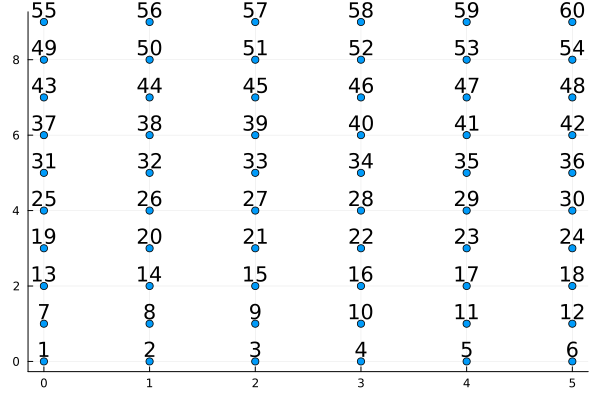

In [112]:
plot_square_lattice(Nx, Ny)

In [113]:
N_Pin = 1 # Dejenerelik sayısı hesabında
V_Strength = 2
V0 = [V_Strength, V_Strength]; Imp_Site = [14, 41]
Impurity_Data = Impurity(V0, Imp_Site)
factor = 5 # particle density interpolation factor
start_point_1 = Impurity_Data.Imp_Site[1]
lens_1 = [3,4,3,4]
dirs_1 = [1, Nx, -1, -Nx]
rec_path_1 = unique(rectangular_path(start_point_1,lens_1,dirs_1))
start_point_2 = Impurity_Data.Imp_Site[2]
lens_2 = [3,4,3,4]
dirs_2 = [-1, -Nx, 1, Nx]
rec_path_2 = unique(rectangular_path(start_point_2,lens_2,dirs_2))
delta_t = 0.01
STEP = 0:delta_t:1
println("Step size for braiding: ",length(STEP))

Step size for braiding: 101


0.0%┣                                                ┫ 0/6 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████████┫ 6/6 [00:00<00:00, 101it/s]
100.0%┣█████████████████████████████████████████████┫ 6/6 [00:00<00:00, 101it/s]
0.0%┣                                               ┫ 0/60 [00:00<00:00, -0s/it]
100.0%┣█████████████████████████████████████████┫ 60/60 [00:00<00:00, 28.1kit/s]
100.0%┣█████████████████████████████████████████┫ 60/60 [00:00<00:00, 27.6kit/s]


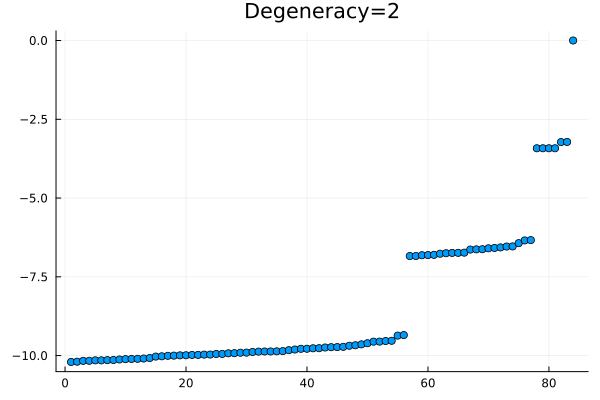

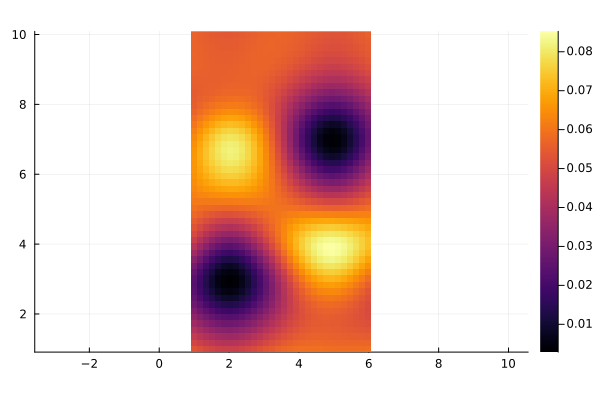

0.0%┣                                             ┫ 0/1.3k [00:00<00:00, -0s/it]
20.3%┣████████▏                               ┫ 267/1.3k [00:00<00:00, 4.9kit/s]
91.2%┣██████████████████████████████████▊   ┫ 1.2k/1.3k [00:00<00:00, 11.4kit/s]
100.0%┣█████████████████████████████████████┫ 1.3k/1.3k [00:00<00:00, 11.8kit/s]
100.0%┣█████████████████████████████████████┫ 1.3k/1.3k [00:00<00:00, 11.7kit/s]
0.0%┣                                             ┫ 0/1.3k [00:00<00:00, -0s/it]
1.5%┣▋                                          ┫ 20/1.3k [00:00<00:03, 375it/s]
4.9%┣██                                         ┫ 64/1.3k [00:00<00:02, 621it/s]
8.4%┣███▌                                      ┫ 110/1.3k [00:00<00:02, 715it/s]
11.9%┣████▉                                    ┫ 156/1.3k [00:00<00:02, 765it/s]
15.7%┣██████▍                                  ┫ 206/1.3k [00:00<00:01, 809it/s]
19.5%┣████████                                 ┫ 256/1.3k [00:00<00:01, 839it/s]
23.3%┣█████████▌            

In [114]:
E, Sub_Number_MB_Operator_List, basis_cut_mb, Degeneracy, Eigen_List, BP = Get_AB_Phase(N, Nx, Ny, p, q, cut_off, PN, U, Impurity_Data);

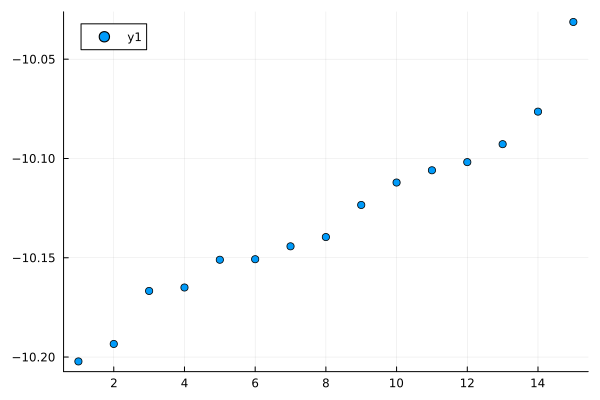

In [117]:
scatter(E[1:15])

In [118]:
BP

2-element Vector{Float64}:
 -0.19893724294038376
  0.029309479537516146

In [119]:
movie(Nx, Ny, Degeneracy, N, Sub_Number_MB_Operator_List, basis_cut_mb, Eigen_List, factor)

LoadError: InterruptException: